# Personality Prediction Framework (v1.0) - unsupervised learning

Developed by: R.T.R Jayasekara

## Required Libraries

In [1]:
from ipywidgets import widgets, interact

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

## Text Preprocessor

In order to work with text data, it is important to transform the raw text into a form that can be understood and used by Machine Learning algorithms, this is called text preprocessing.

The Text Preprocessor component consists of two sub-components; the Normalizer which converts raw text data to text tokens and the Vectorizer which converts the text tokens to vectors.

### Normalizer


In [2]:
# Libraries
import re
import unidecode
import nltk
import emoji
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# Download NLTK words corpora
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [3]:
def normalizer(sentence):
 
    # Remove ||| from kaggle dataset
    sentence = re.sub("[]|||[]", " ", sentence)

    # Handle foreign letters
    sentence = unidecode.unidecode(sentence)

    # Remove numbers
    sentence = re.sub(r'\d+', '', sentence)

    # Make the string lower-case
    sentence = sentence.lower()
    
    # remove reddit subreddit urls
    sentence = re.sub("/r/[0-9A-Za-z]", "", sentence)

    # MBTI types
    MBTI_types = ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp',
              'isfp', 'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj',
              'mbti']

    tokens = nlp(sentence)
    
    words = set(nltk.corpus.words.words())

    tokens = [ti for ti in tokens if ti.lower_ not in STOP_WORDS]
    tokens = [ti for ti in tokens if not ti.is_space]
    tokens = [ti for ti in tokens if not ti.is_punct]
    tokens = [ti for ti in tokens if not ti.like_num]
    tokens = [ti for ti in tokens if not ti.like_url]
    tokens = [ti for ti in tokens if not ti.like_email]
    tokens = [ti for ti in tokens if ti.lower_ not in MBTI_types]
    tokens = [ti for ti in tokens if ti.lower_ in words]

    # lemmatize
    tokens = [ti.lemma_ for ti in tokens if ti.lemma_ not in STOP_WORDS]
    tokens = [ti for ti in tokens if len(ti) > 1]

    return tokens

### Vectorizer

In [4]:
# Libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Read dataframe
df = pd.read_csv("../datasets/posts_dataset.csv")

# Apply normalizer function to the entire dataframe
df["tokens"] = df["posts"].apply(normalizer)

#drop unnecessary from the dataframe
df.drop('posts', inplace=True, axis=1)
df.drop('type', inplace=True, axis=1)

# Saving the dataframe to a csv so that this section need not to run everytime
df.to_csv('../datasets/ppf_dataframe.csv')
df.head(10)

#sample_text = "Final year undergraduate at Sri Lanka Institute of Information Technology, future Software Engineer. My passion for technology made me fall in love with software development and is the reason to follow my BSc (Hons) Information Technology degree program specializing in Software Engineering. #SLIIT 😁"
#sample_text_tokens = normalizer(sample_text)
#print(sample_text_tokens)

In [5]:
# Used to build the TF-IDF vectorizer with the corpus
def fit_tfidf(posts_corpus):
  tf_vect = TfidfVectorizer()
  tf_vect.fit(posts_corpus)
  return tf_vect

# Fit the vectorizer on the corpus, and transform the corpus
df = pd.read_csv("../datasets/ppf_dataframe_kmeans.csv")
tf_vect = fit_tfidf(df["tokens"]) #the tokenized text in the data frame
tf_mtx = tf_vect.transform(df["tokens"])

#tf_vect = fit_tfidf(sample_text_tokens)
#tf_vect.transform(sample_text_tokens).toarray()

#df['vectors'] = pd.DataFrame(tf_mtx.toarray())
#df.to_csv('dataframe_with_vectors.csv')

In [6]:
vectors = tf_mtx.toarray()
print(vectors)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Machine Learning Model

## K-means

### Elbow method

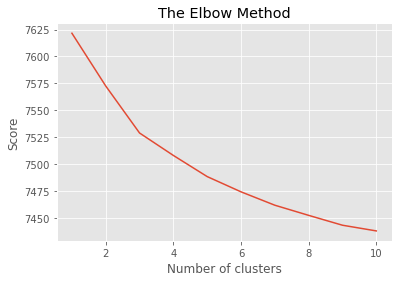

In [7]:
from sklearn.cluster import KMeans

## Elbow method to identify the optimal no of K
k_clusters = 10

score = []
for i in range(1,k_clusters + 1):
    kmeans = KMeans(n_clusters=i,init='k-means++')
    kmeans.fit(tf_mtx)
    score.append(kmeans.inertia_)
plt.plot(range(1,k_clusters + 1 ),score)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.savefig('images/ppf_kmeans_elbow.png')
plt.show()

In [8]:
# Optimal K value (no of clusters)
k_clusters = 4

In [10]:
from sklearn.cluster import KMeans
modelkmeans = KMeans(n_clusters=k_clusters, init='k-means++', n_init=1000)
modelkmeans.fit(tf_mtx)

print(modelkmeans.cluster_centers_)

KeyboardInterrupt: 

In [ ]:
clusters = modelkmeans.predict(tf_mtx)

In [ ]:
df["ClusterName"] = clusters
df.head(20)

### View top terms per cluster

In [ ]:
import seaborn as sns

def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_vect.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs


def plotWords(dfs, n_feats):
    for i in range(0, len(dfs)):
        plt.figure(figsize=(8, 2))
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])

dfs = get_top_features_cluster(tf_mtx.toarray(), clusters, 4)
plotWords(dfs, 4)

In [ ]:
# Just print it to the screen
order_centroids = modelkmeans.cluster_centers_.argsort()[:, ::-1]

terms = tf_vect.get_feature_names()
print(terms)
for i in range(k_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :k_clusters]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))


### Plot the clusters in a scatter plot

In [ ]:
from sklearn.decomposition import PCA

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_mtx.toarray())
kmeans = KMeans(n_clusters=k_clusters, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.figure(figsize=(14, 7))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=40, cmap='viridis', linewidths=5)

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='red', s=200, alpha=0.6);
plt.title('Visualization of Clustered data')
plt.savefig('images/ppf_kmeans_clusters.png')

### Prediction

In [ ]:
# samples
sample_con = [["I always have a plan for the day, week, or year|||I like to be prepared|||I put everything back in its proper place|||I tend to pay attention to small details|||I never wait until the last minute to complete a task|||Planners, calendars, and other organizational tools keep me on track|||When I complete a task, I make sure everything is done right|||My room tends to be clean, even when people are not coming over|||I have a morning routine that I stick to every morning|||I don’t have any problems avoiding cravings or impulse decisions"]]
sample_ext = ["My ideal weekend is surrounded by friends and family|||I don’t feel uncomfortable when I need to take charge of a situation|||People say that I’m the life of the party!|||When things get out of control, I’m likely to take control|||I find new people interesting and exciting|||I fill my days with tons of activities|||I am the most cheerful person in my group of friends!|||Large friend groups are more fulfilling than a tight-knit circle|||I would rather host a party than attend a party|||I never run out of stories to tell"]
sample_agr = ["I trust people easily|||It’s important for me to be honest with the people I love|||Before I make a decision, I think about the impact it will have on others|||I am a generally patient person|||I don’t like to start drama or be involved in conflicts|||There is a lot that other people can teach me|||I tend not to question the motives or intentions of others|||I don’t get annoyed easily|||People would describe me as gentle|||I forgive people easily"]
sample_X = ["conscientiousness"]

In [ ]:
cleaned_data = pd.DataFrame(sample_con, columns=["texts"])
cleaned_data['tokens'] = cleaned_data["texts"].apply(normalizer)

predicted = modelkmeans.predict(tf_vect.transform(cleaned_data['tokens'][0]))
predicted

# cluster 1 => conscientiousness